In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
### sources: 
### Hands-On Machine Learning with Scikit-Learn and TensorFlow by Geron Aurelien, 
### https://corochann.com/mnist-dataset-introduction-532/, 
### https://www.kaggle.com/datasets/zalando-research/fashionmnist?resource=download
### https://github.com/sharmaroshan/MNIST-Using-K-means/blob/master/KMeans%20Clustering%20for%20Imagery%20Analysis%20(Jupyter%20Notebook).ipynb
### https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47
### 

In [3]:
### Important notice: I have commented my experiments with propel classification algorithm selection, even with the dataset scaled, the code
### takes a long time to run. In the comments I gave a short summary of algorithms performance

In [4]:
### Firstly, we need to divide the data into training and testing set

train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [5]:
train.keys()
test.keys()

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [6]:
X_train, X_test, y_train, y_test = train.iloc[:, 1:], test.iloc[:, 1:], train.iloc[:, 0], test.iloc[:, 0]

In [7]:
X_train.shape

(60000, 784)

In [8]:
X_train.keys()

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

In [9]:
X_test.keys()

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

In [10]:
y_train.keys()

RangeIndex(start=0, stop=60000, step=1)

In [11]:
y_train.shape

(60000,)

In [12]:
y_train

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [13]:
### After dividing the dataset into test and training set we can proceed to visualizing and understanding the data

y_train[0]

2

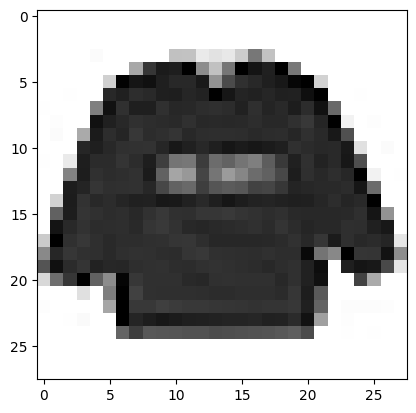

In [14]:
two = X_train.iloc[0].to_numpy()
two_image = two.reshape(28, 28)

plt.imshow(two_image, cmap=mpl.cm.binary, interpolation='nearest')

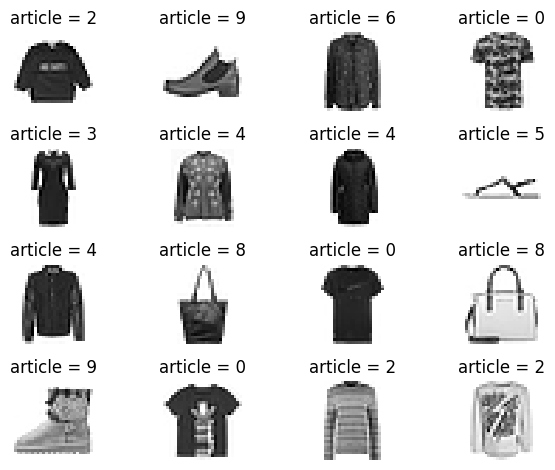

In [15]:
for i in range(4*4):
    image = X_train.iloc[i].to_numpy().reshape(28, 28)
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.title('article = {}'.format(y_train[i]))

plt.tight_layout()
plt.show()

In [16]:
### To summarize, we have a data set that constists of 60 000 training set rows, and 10 000 test set rows, each row contains 784 pixels,
### plotting the pixels in 28x28 shape we can see element of clothing it is

### After understanding what we are working with, we can proceed to dimensionality reduction, this will help us shorten the amount of time and 
### resources needed for training our model, without loosing much precision

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

187


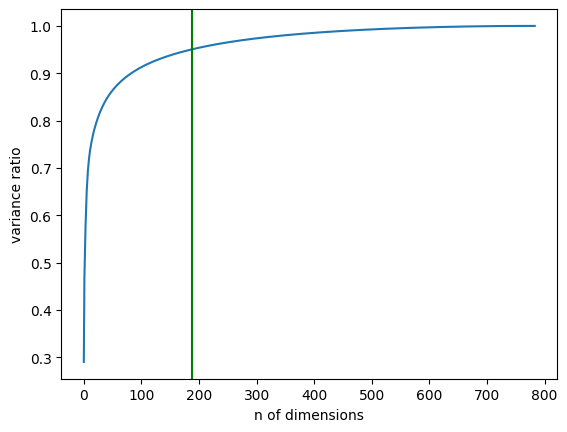

In [17]:
### 187 is the number of dimensions, that we will use. It seems to be good compromise between the dataset size and making the training faster
plt.plot(cumsum)
plt.axvline(x=187, color='g', linestyle='-')
plt.xlabel('n of dimensions')
plt.ylabel('variance ratio')
plt.show()

In [18]:
pca = PCA(n_components=187)
X_train_reduced = pca.fit_transform(X_train)
X_train_reduced.shape
X_train_recovered = pca.inverse_transform(X_train_reduced)
X_train_recovered.shape

(60000, 784)

In [19]:
X_train_recovered.shape

(60000, 784)

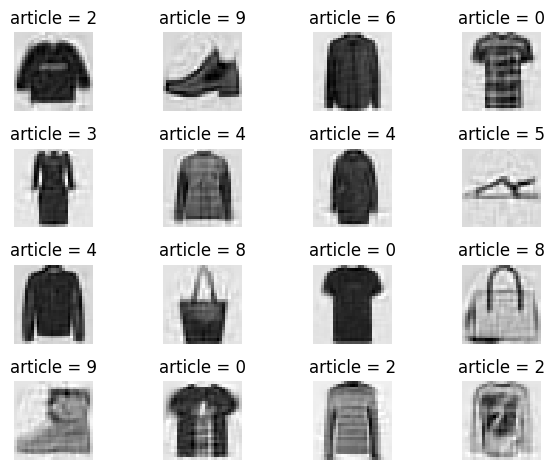

In [20]:


for i in range(4*4):
    image = X_train_recovered[i].reshape(28, 28)
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.title('article = {}'.format(y_train[i]))

plt.tight_layout()
plt.show()

In [21]:
### As we can see, the images have become a bit more blurry, but for the amount of dimensions that we have thrown away it was definetly worth it

### Now onto clustering, most clustering algorithm use 1-D arrays, here its not a problem, because out data set is already suited to that format.
### We will be using mini-batch implementation of the K-means clustering 

from sklearn.cluster import MiniBatchKMeans 
total_clusters = len(np.unique(y_train))
print(total_clusters)

kmeans = MiniBatchKMeans(n_clusters=total_clusters)
kmeans.fit(X_train_reduced)


10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=10)

In [22]:
### By reducing dimensionality before applying clustering we have eliminated some of the noise, this way our algorithm can pick up clusters easier

kmeans.labels_

array([9, 5, 1, ..., 4, 9, 2], dtype=int32)

In [23]:
### This method assigns the most frequent kmeans label to the true one, it may cause the oversimplifing of the model evaluation


def cluster_labels(kmeans, y_train):
    clustered_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        indexes = np.where(kmeans.labels_ == i, 1, 0)
        article = np.bincount(y_train[indexes == 1]).argmax()
        clustered_labels[i] = article
    return clustered_labels
clustered_labels = cluster_labels(kmeans, y_train)
print(clustered_labels)

{0: 5, 1: 4, 2: 7, 3: 1, 4: 6, 5: 9, 6: 0, 7: 9, 8: 3, 9: 8}


In [24]:
predicted_labels = np.zeros_like(y_train)

for i in range(len(kmeans.labels_)):
    predicted_labels[i] = clustered_labels[kmeans.labels_[i]]

print(predicted_labels[:30].astype(np.uint8))
print('',*y_train[:30], sep=' ')

from sklearn.metrics import accuracy_score
print(accuracy_score(predicted_labels, y_train))

[8 9 4 0 3 4 3 5 8 6 0 5 9 4 6 6 9 3 3 5 6 7 6 8 3 4 4 6 7 1]
 2 9 6 0 3 4 4 5 4 8 0 8 9 0 2 2 9 3 3 3 8 7 4 4 0 4 4 8 7 1
0.5282


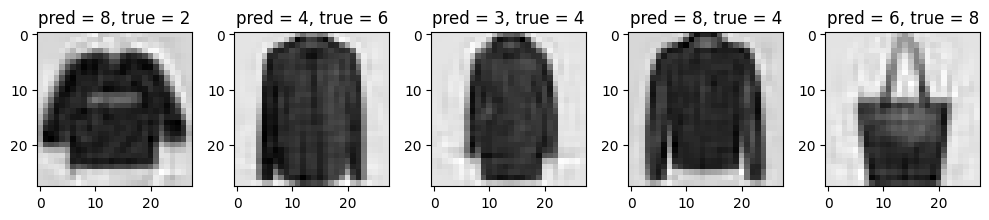

In [25]:
wrong = predicted_labels != y_train
wrong_images = X_train_recovered[wrong]
wrong_pred = predicted_labels[wrong]
wrong_true = y_train[wrong]

plt.figure(figsize=(10,10))
for i in range(len(wrong[:5])):
    plt.subplot(1,5, i+1)
    image = wrong_images[i].reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.title('pred = {}, true = {}'.format(wrong_pred[i], wrong_true.iloc[i]))
plt.tight_layout()
plt.show()

In [26]:
### As we can see, the KMeans clustering performed very bad, it guessed about 55%

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
k_range = list(range(1,12))
param_grid = dict(n_neighbors = k_range)
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')

grid_search = grid.fit(X_train_reduced, y_train)





In [28]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_params_['n_neighbors'])

{'n_neighbors': 6}
0.86065
6


In [29]:
### Best accuracy that we can get out of KNN algorithm is 86% for 4/6/8 neighbors, lets try 2 other algorithms

## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## I have commented this part of the code, because it takes a long time to compile

# from sklearn.linear_model import SGDClassifier 
# from sklearn.model_selection import cross_val_score
# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train_reduced, y_train)
# cross_val_score(sgd_clf, X_train_reduced, y_train, cv=3, scoring='accuracy')


In [30]:
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## I have commented this part of the code, because it takes a long time to compile

# from sklearn.preprocessing import StandardScaler 
# scaler = StandardScaler()
# X_train_reduced_scaled = scaler.fit_transform(X_train_reduced.astype(np.float64))
# cross_val_score(sgd_clf, X_train_reduced_scaled, y_train, cv=3, scoring='accuracy')


In [31]:
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# grid_search = grid.fit(X_train_reduced_scaled, y_train)


In [32]:
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [33]:
### Using StandardScaler with SGDClassifier improved the models accuracy from ~80% to ~83%, but its still worse than KNN,
### on the other hand, using StandardScaler with the KNN decreased the models performance

## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## I have commented this part of the code, because it takes a long time to compile

# from sklearn.ensemble import RandomForestClassifier

# forest_clf = RandomForestClassifier(random_state=42)
# forest_clf.fit(X_train_reduced, y_train)
# cross_val_score(forest_clf, X_train_reduced, y_train, cv=3, scoring='accuracy')

In [34]:
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## I have commented this part of the code, because it takes a long time to compile

# forest_clf.fit(X_train_reduced_scaled, y_train)
# cross_val_score(forest_clf, X_train_reduced_scaled, y_train, cv=3, scoring='accuracy')

In [35]:
### Final classification



X_test_reduced = pca.transform(X_test)
X_test_reduced.shape

(10000, 187)

In [36]:
X_train_reduced.shape

(60000, 187)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
knn_test = KNeighborsClassifier(n_neighbors = grid_search.best_params_['n_neighbors'])
knn_test.fit(X_train_reduced, y_train)

y_pred = knn_test.predict(X_test_reduced)
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))

0.8699
[[884   6  17  31   3   0 205   0   2   0]
 [  1 969   0   6   0   0   1   0   1   0]
 [ 17   5 811  16 102   0 103   0  14   0]
 [ 13  14  15 898  29   0  19   0   2   0]
 [  7   1  88  31 799   0  74   0   6   0]
 [  0   0   0   0   0 878   0   7   2   3]
 [ 69   5  66  18  65   4 588   0   6   0]
 [  2   0   0   0   0  61   0 952   4  38]
 [  7   0   3   0   2   5  10   0 961   0]
 [  0   0   0   0   0  52   0  41   2 959]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.76      0.81      0.78      1000
           3       0.91      0.90      0.90      1000
           4       0.79      0.80      0.80      1000
           5       0.99      0.88      0.93      1000
           6       0.72      0.59      0.65      1000
           7       0.90      0.95      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.

In [38]:
### So thats it, the final accuracy is ~87% on a test set

